In [1]:
# System
import os
import sys

# Maths
import numpy as np
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Atoms
from ase.io import read, write

# Plotting
import matplotlib.pyplot as plt

# SOAP density utilities
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
from soap import reshape_soaps, librascal_soap, compute_soap_density

# General utilities
import project_utils as utils

In [2]:
# TODO: contraction with GTOs

# Setup

In [3]:
# Load frameworks
deem_10k = read('../Raw_Data/DEEM_10k/DEEM_10000.xyz', index=':')
iza_230 = read('../Raw_Data/GULP/IZA_230/IZA_230.xyz', index=':')

In [4]:
deem_idxs = np.arange(0, len(deem_10k))
np.random.shuffle(deem_idxs)
n_deem_train = 9000
deem_train_idxs = deem_idxs[0:n_deem_train]
deem_test_idxs = deem_idxs[n_deem_train:]

iza_train_idxs = np.loadtxt('../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../Processed_Data/IZA_230/svm_test.idxs', dtype=int)

In [5]:
iza_cantons = np.ones(len(iza_230), dtype=int)
deem_cantons = np.ones(len(deem_10k), dtype=int) * 2

In [6]:
species = np.unique([np.unique(frame.get_atomic_numbers()) for frame in deem_10k+iza_230])
n_species = len(species)

# Compute SOAPs

In [7]:
# SOAP hyperparameters
soap_hyperparameters = dict(
    soap_type='RadialSpectrum',
    radial_basis='GTO',
    max_radial=12,
    max_angular=9,
    interaction_cutoff=6.0,
    gaussian_sigma_type='Constant',
    gaussian_sigma_constant=0.3,
    cutoff_smooth_width=0.3,
    normalize=False
)

soap_args = dict(
    center_species=[14],
    representation='SphericalInvariants',
    average=True,
    concatenate=True
)

In [8]:
# Compute SOAPs
deem_soaps = librascal_soap(
    deem_10k,
    **soap_hyperparameters,
    **soap_args
)
iza_soaps = librascal_soap(
    iza_230,
    **soap_hyperparameters,
    **soap_args
)

# SVM

In [9]:
train_soaps = np.vstack((iza_soaps[iza_train_idxs], deem_soaps[deem_train_idxs]))
train_cantons = np.concatenate((iza_cantons[iza_train_idxs], deem_cantons[deem_train_idxs]))

test_soaps = np.vstack((iza_soaps[iza_test_idxs], deem_soaps[deem_test_idxs]))

In [10]:
train_class_weights = utils.balanced_class_weights(train_cantons)

In [11]:
parameter_grid = dict(svc__estimator__C = np.logspace(-3, 3, 7))
fit_params = {'norm_scaler__sample_weight': train_class_weights}

In [12]:
pipeline = Pipeline(
    [
        ('norm_scaler', utils.StandardNormScaler()),
        ('kernel_constructor', utils.KernelConstructor()),
        ('svc', OneVsRestClassifier(SVC(kernel='precomputed', class_weight='balanced')))
    ]
)

gscv = GridSearchCV(
    pipeline, parameter_grid,
    scoring='balanced_accuracy',
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=0),
    refit=True, error_score='raise', n_jobs=4
)

gscv.fit(train_soaps, train_cantons, **fit_params)
test_dfs = gscv.decision_function(test_soaps)

svc_estimator = gscv.best_estimator_.named_steps['svc'].estimators_[0]
norm_scaler = gscv.best_estimator_.named_steps['norm_scaler']

support_idxs = svc_estimator.support_
support_vectors = norm_scaler.transform(train_soaps)[support_idxs]
weights = svc_estimator.dual_coef_ @ support_vectors
intercept = svc_estimator.intercept_

In [13]:
gscv.cv_results_

{'mean_fit_time': array([0.76038897, 0.52324069, 0.33011377, 0.37762928, 0.41701567,
        0.51566195, 1.05367029]),
 'std_fit_time': array([0.03632629, 0.02288878, 0.00143063, 0.01393104, 0.02847278,
        0.03314281, 0.38993776]),
 'mean_score_time': array([0.3467437 , 0.27493954, 0.41158366, 0.36106586, 0.25676024,
        0.27472377, 0.13178933]),
 'std_score_time': array([0.01026118, 0.00693941, 0.00885248, 0.00955272, 0.04409778,
        0.06542993, 0.00454962]),
 'param_svc__estimator__C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'svc__estimator__C': 0.001},
  {'svc__estimator__C': 0.01},
  {'svc__estimator__C': 0.1},
  {'svc__estimator__C': 1.0},
  {'svc__estimator__C': 10.0},
  {'svc__estimator__C': 100.0},
  {'svc__estimator__C': 1000.0}],
 'split0_test_score': array([0.82394152, 0.90869006, 0.93535088, 0.91847953, 0

# Real-space

In [14]:
reshape_args = dict(n_pairs=n_species, n_max=soap_hyperparameters['max_radial'])

test_species_soaps = reshape_soaps(
    norm_scaler.transform(test_soaps), **reshape_args
)

species_weights = reshape_soaps(
    weights, **reshape_args
)

In [15]:
print(test_dfs)
print(np.dot(norm_scaler.transform(test_soaps), weights.T).T + intercept)
print(np.sum(species_weights * test_species_soaps, axis=(-1, -2)) + intercept)

[-1.36899185 -6.31248551 -3.76278683 ... 10.58741743 10.5920614
  8.26038644]
[[-1.36899185 -6.31248551 -3.76278683 ... 10.58741743 10.5920614
   8.26038644]]
[-1.36899185 -6.31248551 -3.76278683 ... 10.58741743 10.5920614
  8.26038644]


In [16]:
r_grid = {}
r_grid['DVR'] = np.linspace(
    0.0, soap_hyperparameters['interaction_cutoff'] + 3 * soap_hyperparameters['gaussian_sigma_constant'], 10000
)
r_grid['GTO'] = np.linspace(
    0.0, soap_hyperparameters['interaction_cutoff'] * 2, 1000
)
dr = np.diff(r_grid[soap_hyperparameters['radial_basis']])[0]

density_args = dict(
    cutoff=soap_hyperparameters['interaction_cutoff'],
    n_max=soap_hyperparameters['max_radial'],
    r_grid=r_grid[soap_hyperparameters['radial_basis']],
    chunk_size_r=10,
    radial_basis=soap_hyperparameters['radial_basis'],
    gaussian_sigma=soap_hyperparameters['gaussian_sigma_constant'],
    projection_matrix=None
)

soap_density = compute_soap_density(
    test_species_soaps,
    **density_args
)

weight_density = compute_soap_density(
    species_weights,
    **density_args
)

In [17]:
print(dr * np.sum(soap_density * weight_density, axis=(-1, -2)) + intercept)

[-1.36899539 -6.31248337 -3.7627859  ... 10.58741789 10.5920611
  8.26038562]


In [18]:
n_r = n_species * len(r_grid[soap_hyperparameters['radial_basis']])
print(np.trapz(
    y=np.sum(soap_density * weight_density, axis=-2),
    x=r_grid[soap_hyperparameters['radial_basis']]
) + intercept)

[-1.3689954  -6.31248335 -3.76278589 ... 10.5874179  10.59206112
  8.26038561]


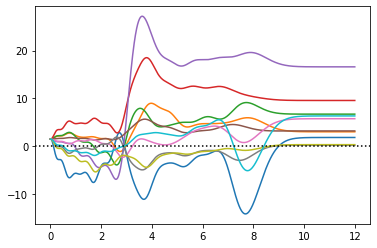

In [19]:
idxs = np.arange(0, soap_density.shape[0])
np.random.shuffle(idxs)
for i in idxs[0:10]:
    plt.plot(
        r_grid[soap_hyperparameters['radial_basis']], 
        dr * np.cumsum(np.sum(soap_density[i] * weight_density[0], axis=0)) + intercept
    )

plt.axhline(0, color='k', linestyle=':')
plt.show()